In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_palette('magma_r')

## MNIST :

We're using the MNIST Dataset in this chapter, which consists of 70,000 images, where each image has 784 features (28 x 28 pixels), each representing the intensity of the pixel ranging from 0 to 255. Since, MNIST is one among the popular datasets, it can be imported directly from scikit-learn as shown below.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


	Label: 5


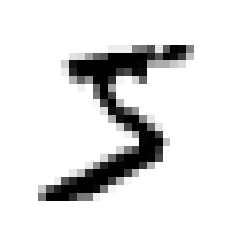

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

print('\tLabel:', y[0])
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

Each image has a label which tells us what the digit actually is and this case we can see that both the image and the label tell us that it's 5. The labels are originally strings so we type cast them to integers as shown.

In [5]:
print(type(y[0]))
y = y.astype(np.uint8)
print(type(y[0]))

<class 'str'>
<class 'numpy.uint8'>


Let's have a look at some more examples (100-200)

In [6]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis('off')

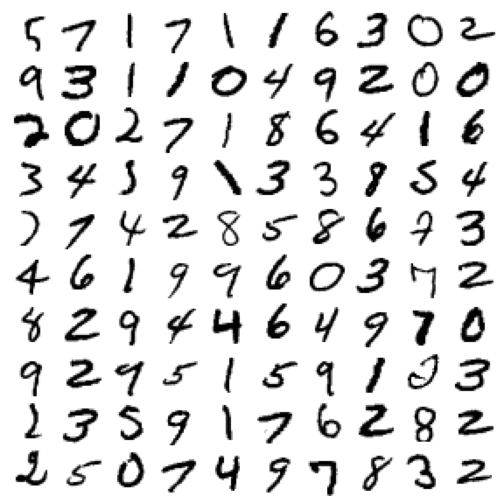

In [7]:
plt.figure(figsize=(9, 9))
example_images = X[100:200]
plot_digits(example_images, images_per_row=10)
plt.show()

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Splitting the test set from the data. (In MNIST Dataset, test set is set as the last 10,000 images and hence, the first 60,000 act as the train split which are already shuffled)

## Binary Classifier (5-Detector) :

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Now that we have created target vectors for both training and testing, we start training the classifiers starting from Stochastic Gradient Descent (SGD) which is capable of handling large datasets efficiently.

In [10]:
from sklearn.linear_model import SGDClassifier

# max_iter and tol are explicitly set to avoid version errors
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
# some_digit is (X[0]) = 5
sgd_clf.predict([some_digit])

array([ True])

The classifier was able to tell that the image represented the digit 5 but to evaluate the accuracy we need performance measures. First, we start with the cross-validation score (first version is the general implementation of the second)

In [12]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

We get an accuracy of above 95% on all cross-validation folds. Below we've made a classifier that predicts all images as not-5 and check the accuracy.

In [14]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Even by classifying all images as not-5, we get an accuracy of above 90% in all the three folds. This happens because only 10% of the images represent the digit 5, so even if we assume that no image represents 5, we are right almost 90% of the times. This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when we are dealing with skewed datasets (i.e., when some classes are much more frequent than others).